# Ensemble Bootstrap Prediction Intervals

In [1]:
# We install Amazon Fortuna. An open-source library aimed at uncertainty quantification
!pip install aws-fortuna


In [2]:
# We use bike haring demand dataset, available on scikit-learn
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor

from fortuna.conformal import EnbPI
from fortuna.metric.regression import prediction_interval_coverage_probability
     

from sklearn.datasets import fetch_openml

In [3]:
bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2,
as_frame=True, parser="pandas")

In [4]:
# The actual pandas DataFrame
df=bike_sharing.frame

df.shape

(17379, 13)

In [5]:
df.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0,1


The dataset contains information about bike-sharing rentals, including additional infomation such as temperature, humidity and wind speed. The problem requires forecasting bike sharing demand expressed in the count of renting bikes

In [6]:
# We calculate the demand, grouped by weekday and hour
df.groupby(["weekday","hour"])["count"].mean()

weekday  hour
0        0        93.990385
         1        77.432692
         2        61.627451
         3        31.144231
         4         9.362745
                    ...    
6        19      239.932692
         20      180.865385
         21      156.000000
         22      139.663462
         23      115.855769
Name: count, Length: 168, dtype: float64

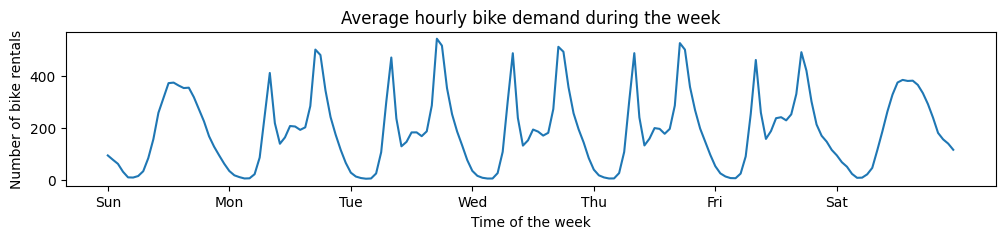

In [7]:
fig, ax = plt.subplots(figsize=(12, 2))
average_week_demand= df.groupby(["weekday","hour"])["count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [8]:
# We randomly select 500 rows from the full dataset
df=df.sample(500)
# We create the target cvariable y , which the bike demand (count) normalized between 0 and 1
# df["count"]--> The demand values
# /df["count"].max()--> scales all values so the largest becomes 1
# this normalization hels many ML models to train better
y = df["count"]/df["count"].max()
# We create the feature matrix X by removng the target column
# X containes all input variables: season, hour, tmp. etc
# y conttains only the value we want to predict: count
X = df.drop("count", axis="columns")
# We split the features into: training data (80%) and test data(20%)
# shuffle=False means the data will not be randomly shuffles.Impotant fo time-series where order matters
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
# The same split , but for the target values
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)


## Data bootstrapping

EnbPI requires bootstrapping he data. We sample with replacement random subsets of the time series and training a model for each of these samples

In [9]:
class DataFrameBootstrapper:
    def __init__(self, n_samples: int):
        # How many bootstrap datasets we want to generate
        self.n_samples = n_samples

    def __call__(self, X, y):
        n_rows = len(y)

        # Step 1: Generate random indices for each bootstrap dataset
        # Shape: (n_bootstrap_samples, n_rows)
        bootstrap_indices = np.random.choice(
            a=n_rows,
            size=(self.n_samples, n_rows),
            replace=True
        )

        # Step 2: Create bootstrap datasets using the generated indices
        bootstrap_datasets = []
        for index_set in bootstrap_indices:
            X_sample = X.iloc[index_set]
            y_sample = y.iloc[index_set]
            bootstrap_datasets.append((X_sample, y_sample))

        # Return the indices + the actual bootstrap samples
        return bootstrap_indices, bootstrap_datasets


In [10]:
n_bs_samples = 10
bs_indices, bs_train_data = DataFrameBootstrapper(n_samples=n_bs_samples)(
    X_train, y_train
)


# returns 10 boostrap samples from the training set
bs_indices.shape
     


(10, 400)

In [11]:
# The array of indices for each bootstrap sample
bs_indices

array([[249, 263, 258, ..., 361,  92,  20],
       [331, 132, 157, ..., 259,  19,  37],
       [132, 205,  17, ..., 229, 182, 143],
       ...,
       [361, 390,  24, ...,  92, 119, 194],
       [383, 354, 298, ...,  23,  90, 326],
       [  2,  27, 293, ..., 182,  73,  71]])

In [12]:
# The first bootstrap sample -X
bs_train_data[0][0]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
9624,spring,1,2,23,False,5,True,misty,12.30,15.910,0.70,6.0032
7197,winter,0,11,12,False,2,True,clear,20.50,24.240,0.48,6.0032
496,spring,0,1,18,False,6,False,clear,3.28,4.545,0.35,12.9980
2771,summer,0,4,9,False,6,False,clear,18.04,21.970,0.51,23.9994
16974,winter,1,12,1,False,6,False,misty,10.66,14.395,0.81,6.0032
...,...,...,...,...,...,...,...,...,...,...,...,...
3775,summer,0,6,5,False,6,False,clear,27.88,31.820,0.74,8.9981
14455,fall,1,8,12,False,4,True,clear,31.16,34.090,0.45,8.9981
14972,fall,1,9,1,False,5,True,clear,21.32,25.000,0.72,0.0000
16449,winter,1,11,3,False,5,True,clear,10.66,15.150,0.70,0.0000


In [13]:
# The first boostrap sample y
bs_train_data[0][1]

9624     0.070499
7197     0.190889
496      0.058568
2771     0.169197
16974    0.103037
           ...   
3775     0.017354
14455    0.318872
14972    0.053145
16449    0.001085
6437     0.405640
Name: count, Length: 400, dtype: float64

# Get a boolean series where True indicates the index is duplicated
duplicate_indices = bs_train_data[0][0].index.duplicated(keep=False)

# Print the duplicated indices
print(bs_train_data[0][0].index[duplicate_indices])

## Model definition

In [14]:
# We define categorical clumn names. These are the columns in our DataFrame that contain categories(strings), not numerical values
categorical_columns = ["weather", "season", "holiday", "workingday"]


In [15]:
# We define the allowed categories for each column
# This tells the OrdinalEncoder exaclty what cateogires exist in each column and their order
# Ordinal encoding maps categorie -->integers
categories = [
    ["clear", "misty", "rain", "heavy_rain"],
    ["spring", "summer", "fall", "winter"],
    ["False", "True"],
    ["False", "True"],
]


In [16]:
""" We create an ordinal encoder for those categories
This encoder converts strings-> integers
| weather      | season   | holiday | workingday | → After encoding |
| ------------ | -------- | ------- | ---------- | ---------------- |
| "clear"      | "fall"   | "False" | "True"     | 0, 2, 0, 1       |
| "heavy_rain" | "spring" | "True"  | "False"    | 3, 0, 1, 0       |
"""
ordinal_encoder = OrdinalEncoder(categories=categories)


We use ordinal encoding because HIstGradientBoostinRegressor (HGBR) can treat integers as categorical splits, not as numeric order, when you tell which features are categorical

In [17]:
# We use ColumnTransformer to apply encoding only to the categorical columns. We leave the other columns unchanged
c_transformer=ColumnTransformer(
    transformers=[
        ("categorical", ordinal_encoder, categorical_columns),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)


After transformation catecorigal columns bcome integers and numeric columns remain numeric. The order of columns is preserved

In [18]:
""" We build a pipeline
Step 1: Trasnforms the DataFrame: categorical->encoded integers and numeric-->unchanged
Step 2: HistGadientBoostingRegressor. A tree based rmodel. Supports categorical features direclty as integer encoded
We tel HGBR model which columns are categorical Even though tey are encoded as integeres , the model treats them as categories, not numbers"""
gbrt_pipeline = make_pipeline(
    c_transformer,
    HistGradientBoostingRegressor(
        categorical_features=categorical_columns,
    ),
).set_output(transform="pandas") # This makes all transformers and the pieline return pandas Dataframes , not numPY arrays


## Model training for each bootstrap sample 

In [19]:
"""n_bs_samples = number of bootstrap datasets
   X_train.shape[0] = numbr of training samples
   X_test.shape[0] = number of test samples"""
bs_train_preds = np.zeros((n_bs_samples, X_train.shape[0]))
bs_test_preds = np.zeros((n_bs_samples, X_test.shape[0]))


In [20]:
""" The training loop
Each batch is (X_bootstrap, y_bootstrap)
"""
for i,batch in enumerate(bs_train_data):
    #We train a new model on a bootstrap sample, we fit a different model each time because, the training data is different, 
    #duplicate samples distort the training distribution, some original points are missing in some bootstrap datasets. 
    #This is how ensemble get diversity,
    gbrt_pipeline.fit(*batch)
    # Predicton on the original training data. We need predictions for every training point from every bootstrap model. 
    #EnbPI computes residuals
    bs_train_preds[i] = gbrt_pipeline.predict(X_train)
    # Predict on the test data. This gives 10 different predictions for each test sample
    #These for the baeline for creating prediction intervals
    bs_test_preds[i] = gbrt_pipeline.predict(X_test)

In [21]:
"""Passing predictions to EnbPI
Step 1: Compute per-sample residuals. For each trainin sample j:EnbPI uses leave one-out residual estimate. 
        We remove models that used sample j for training--> Avoids overfitting
Step 2: Find the quantile of residuals
Step 3: For each test point y(x)=average of bootstrap predictions at that point interval=[ y(x)−q,  y(x)+q ]
"""


conformal_intervals = EnbPI().conformal_interval(
    bootstrap_indices=bs_indices,
    bootstrap_train_preds=bs_train_preds,
    bootstrap_test_preds=bs_test_preds,
    train_targets=y_train.values,
    error=0.05,
)
     


In [22]:
# In order to evaluate conditional coverage, we measure the Prediction Interval Coverage Probability (PICP), i.e. the percentage of
# test target variables that actually falls within the conformal intervals. We further measure the percentage of intervals that contain the point
# predictions given by the model. Finally, we measure the size of the conformal intervals, which EnbPI takes to be the same for every intervals
# if no online feedback is provided, like in this case.

In [23]:
# For each test point, does the the interval [lower bound, Higher bound] contain the ensemble mean prediction? How often does that happen?
print(
    
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, bs_test_preds.mean(0))}."
)
# For each test point i, is the true value y inside its inteval [lower bound, higher bound]?
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, y_test.values)}."
)
# We perform Higher bound - Lower boudn to compute the size of cnofromal intervals
print(f"Size of the conformal intervals: {np.diff(conformal_intervals)[0][0]}")
     

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.949999988079071.
Size of the conformal intervals: 0.42193177342414856


In the example above, EnbPI assumes that all the predictions in the test dataset are done at once, without any online feedback from incoming observations of the test targets. As a consequence, the size of the conformal intervals is the same for all test data points.

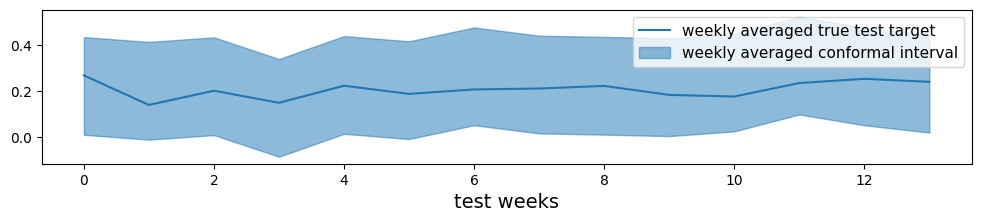

In [24]:
# Given a sequence of values ordered in timeL Groups the data into chunks of 7.
# Because the dataset is daily indexed and also averages each group--> giving you one number per weak
# Instea dof plotting 100 poitns the plot shows a smoothed weakly trend
def weakly_avg(x):
    # Compute the number of complete 7-length periods
    # 103//7 =14 --> 14 "full weaks"
    s = x.shape[0] // 7
    # Trim extra values so the number is divisible by 7
    x = x[: s * 7]
    # Reshape into a 7xs matrix. Return the average of one weak
    return x.reshape(7, s, *x.shape[1:]).mean(0)

# Weakly averaged true target values
weekly_avg_test = weakly_avg(y_test.values)
# n_weaks--> number of weaks
n_weeks = weekly_avg_test.shape[0]

plt.figure(figsize=(12, 2))
# PLots the weakly mean for the true target values
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
# The plot shows weakly averaged true targets values and weakly averaged prediction intervals
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

## EnbPI with online FeedBack

we compute conformal intervals one test point at a time, instead of all at once. THis is called online conformal prediction, because after you observe the true value at step t, you update your residuals and refine the next intervlas.

In [25]:
# batch_size = 1 means: we compute one interval at a time
# update residuals after every few observations
#conformal_intevlas2 stores the online intervlas

batch_size = 1
conformal_intervals2 = np.zeros((len(y_test), 2))
# if batch_size=1->loop over each test sample
for i in range(0, len(y_test), batch_size):
    """step 1: Compute first interval normally: use bootstrap predictions, use training targets, 
               compute prediction interval for the first test point 
       step 2: return_residuals: The initial conformal interval, the set residulas, which will be updated as new true values arrive"""
    if i == 0:
        conformal_intervals2[:batch_size], train_residuals = EnbPI().conformal_interval(
        bootstrap_indices=bs_indices,
        bootstrap_train_preds=bs_train_preds,
        bootstrap_test_preds=bs_test_preds[:, :batch_size],
        train_targets=y_train.values,
        error=0.05,
        return_residuals=True,
        )
    # THIS IS THE ONLINE UPDATE STEP
    # We just predicted the interval for point i-1
    # Now we observe the true value y_test[i-1], we update bootstrap predictions, residuals, error distribution.
    # This is how EnbPI adapts to distribution shift
    # Using updatedresiduals, bootstrap predictions for next test point
    else:
        (
            conformal_intervals2[i : i + batch_size],
            train_residuals,
        ) = EnbPI().conformal_interval_from_residuals(
            train_residuals=train_residuals,
            bootstrap_new_train_preds=bs_test_preds[:, i - batch_size : i],
            bootstrap_new_test_preds=bs_test_preds[:, i : i + batch_size],
            new_train_targets=y_test.values[i - batch_size : i],
            error=0.05,
        )
     

Similarly as done above , we compute the percentage of preictions as true targets falling within the conformal intervals. Againm it is good to see that all confromal intervals include the oint predictions. Also , thepercentage of intervlas contianing the true targets increased to around 83 %, getinng closer to the desired coverage

In [26]:


print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, y_test.values)}."
)
     


Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.9399999976158142.


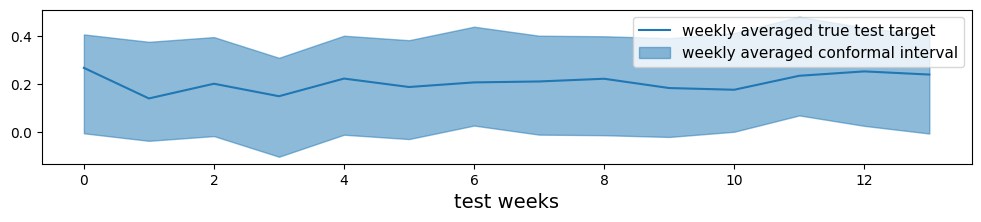

In [27]:
plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals2).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

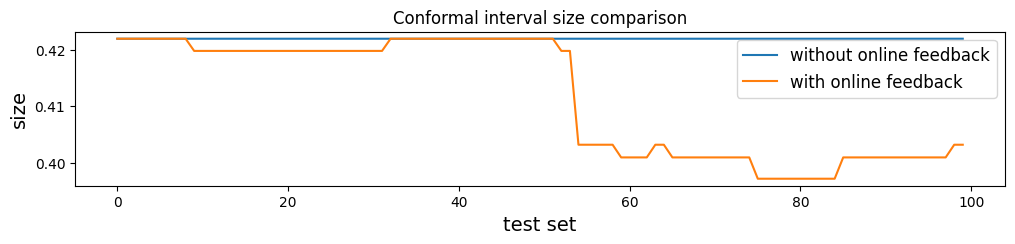

In [28]:
# The following plot compares the size of the intervals without and with online feedback.
plt.figure(figsize=(12, 2))
plt.title("Conformal interval size comparison")
plt.plot(np.diff(conformal_intervals), label="without online feedback")
plt.plot(np.diff(conformal_intervals2), label="with online feedback")
plt.xlabel("test set", fontsize=14)
plt.ylabel("size", fontsize=14)
plt.legend(fontsize=12)

We should remark that the feedback on the conformal intervals was was provided without having to retrain the model . However, if the distribution of the data start drifting over time, the confromal intervals may progressively become large and unusable. In such case, one may track the confromal interval size and trigger retraining after it reaches a certain threshod